In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Global variable to store cached data in memory
global_cache_data_analog = None
global_processed_files_analog = None

In [3]:
import os
import shutil
import os
import pickle
import re
import numpy as np
from pathlib import Path

def inspect_cache_file(cache_path):
    """Inspect the contents of the cached_results.pkl file and print the number of processed files for each N_ctrl."""
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            try:
                cached_data, processed_files = pickle.load(f)
                print(f"Cache file loaded successfully from: {cache_path}")

                # Print the total number of processed files
                print(f"\n---- Total Number of Processed Files: {len(processed_files)} ----")

                print("\n---- Number of Processed Files for Each N_ctrl ----")
                for N_ctrl, gates_data in cached_data.items():
                    # Calculate the number of processed files for this N_ctrl
                    num_processed_for_ctrl = sum(
                        len(runs_data) for gate_data in gates_data.values()
                        for reservoir_data in gate_data.values()
                        for runs_data in reservoir_data.values()
                    )
                    print(f"N_ctrl={N_ctrl}: {num_processed_for_ctrl} processed files.")

            except (EOFError, pickle.UnpicklingError) as e:
                print(f"Error loading cache file: {e}")
    else:
        print(f"Cache file not found: {cache_path}")
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False
def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data  # Return as is if not an array or collection

def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0

def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        
        # Clean any deprecated arrays in the data
        df = clean_array(df)
        
        costs = [float(i) for i in df['costs'][0]]
        fidelity = df['avg_fidelity'][0]
        test_results = [float(a) for a in df['testing_results'][0]]
        num_params = 3 + int(df['trotter_step'][0]) + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        grads_per_epoch = df['grads_per_epoch'][0]
        try:
            selected_indices = df['selected_indices'][0]
        except KeyError:
            selected_indices = None
        return costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices


def get_cached_data(cache_file):
    """Load cached data and list of processed files from a specified cache path."""
    start_time = time.time()
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
            # Clean arrays to ensure compatibility
            cached_data = clean_array(cached_data)
        load_time = time.time() - start_time
        print(f"Loaded {len(processed_files)} processed files from cache. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file not found: {cache_file}")
        return {}, set()
def get_cached_data_once(base_path, N_ctrl):
    """Load cached data only once and keep it in memory for future runs, with different cache paths based on N_ctrl."""
    global global_cache_data_analog, global_processed_files_analog
    start_time = time.time()

    # Define cache file based on N_ctrl
    if N_ctrl == 3:
        cache_file = os.path.join(base_path, f'trainsize_20_optimized_by_cost3/0/cached_results.pkl')
    else:
        cache_file = os.path.join(base_path, 'trainsize_10_optimized_by_cost3/0/cached_results.pkl')

    # If the cache has already been loaded, skip re-loading
    if global_cache_data_analog is not None and global_processed_files_analog is not None:
        print("Using cached data from memory, not reloading from disk.")
        return global_cache_data_analog, global_processed_files_analog

    # Load the cache from disk (only happens once)
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            global_cache_data_analog, global_processed_files_analog = pickle.load(f)
        print(f"Cache file loaded from disk: {cache_file}")
        global_cache_data_analog = clean_array(global_cache_data_analog)
        load_time = time.time() - start_time
        print(f"Loaded {len(global_processed_files_analog)} processed files from cache. Took {load_time:.2f}s.")
        return global_cache_data_analog, global_processed_files_analog
    else:
        print("Cache file not found.")
        global_cache_data_analog = {}
        global_processed_files_analog = set()
        return global_cache_data_analog, global_processed_files_analog
def get_cached_data_for_N_ctrl(base_path, N_ctrl):
    """Load cached data specific to the given N_ctrl value and return its contents."""
    cache_file = os.path.join(base_path, f'results_Nc_{N_ctrl}.pkl')
    start_time = time.time()

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file for N_ctrl={N_ctrl} not found.")
        return {}, set()  # Return empty structures if no cache exists
def get_cached_data_direct_path(cache_file, N_ctrl):
    """Load cached data specific to the given N_ctrl value and return its contents."""
    
    start_time = time.time()

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file for N_ctrl={N_ctrl} not found.")
        return {}, set() 
def save_cached_data_for_N_ctrl(base_path, cached_data, processed_files, N_ctrl):
    """Save cached data and processed files specific to the given N_ctrl value."""
    cache_file = os.path.join(base_path, f'analog_results_Nc_{N_ctrl}.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
    print(f"Cache for N_ctrl={N_ctrl} saved to {cache_file}")


def process_files_by_N_ctrl(base_path, gate_prefixes, reservoir_counts, trots, N_ctrl):
    """Main process to load, update, and save cache for each N_ctrl."""
    # Load cached data for current N_ctrl
    cached_data, processed_files = get_cached_data_for_N_ctrl(base_path, N_ctrl)

    # Process new files and update the cache
    cached_data, processed_files = process_new_files(
        base_path, gate_prefixes, reservoir_counts, trots,
        cached_data, processed_files, N_ctrl
    )

    # Save the updated cache for current N_ctrl
    save_cached_data_for_N_ctrl(base_path, cached_data, processed_files, N_ctrl)

def get_cached_data_direct_path(filepath, N_ctrl):
    start_time = time.time()
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files

def process_files_by_direct_path(filepath, gate_prefixes, reservoir_counts, trots, N_ctrl):
    """Main process to load, update, and save cache for each N_ctrl."""
    # Load cached data for current N_ctrl
    cached_data, processed_files = get_cached_data_direct_path(filepath, N_ctrl)

    # Process new files and update the cache
    cached_data, processed_files = process_new_files(
        filepath, gate_prefixes, reservoir_counts, trots,
        cached_data, processed_files, N_ctrl
    )





def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and processed files."""
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)

def process_new_files(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                
                for bath_status in ['bath_True', 'bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')
                                    current_best_data_point = None

                                    # Ensure N_ctrl is in cached_data
                                    if N_ctrl not in cached_data:
                                        cached_data[N_ctrl] = {}

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.normpath(os.path.join(trotter_path, file))

                                            # Ensure the file belongs to the correct base path
                                            if not pickle_file.startswith(base_path):
                                                continue

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                continue
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Process the file if it's valid
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                if N_ctrl == 2 and trotter_step >20:
                                                    print(pickle_file)
                                                costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices = read_jax_file(pickle_file, gate)

                                                # Update the best fidelity
                                                if fidelity > current_best_fidelity:
                                                    current_best_fidelity = fidelity
                                                    current_best_data_point = {
                                                        'costs': costs,
                                                        'gate': gate,
                                                        'fidelity': fidelity,
                                                        'test_results': test_results,
                                                        'param_count': num_params,
                                                        'run': run,  # Store the data_run_<i> value
                                                        'grads_per_epoch': grads_per_epoch,
                                                        'selected_indices': selected_indices,
                                                        'file_path': pickle_file  # Add the file path
                                                    }

                                                # Add processed file to the global set
                                                processed_files.add(pickle_file)

                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]

    return cached_data, processed_files


def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                # print(f"Processing gate: {gate}")

                for bath_status in ['bath_True', 'bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue
                            # print(f"Processing reservoir: {reservoir_count}")

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue
                                    # print(f"Processing trotter step: {trotter_step}")

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    
                                    # Ensure that N_ctrl is in cached_data
                                    if N_ctrl not in cached_data:
                                        cached_data[N_ctrl] = {}

                                    # Initialize the cached_trotter_data
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.normpath(os.path.join(trotter_path, file))

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                # print(f"Skipping file {pickle_file}, already processed.")
                                                # Update the run field in cached data if missing
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or cached_result['run'] != run:
                                                        cached_result['run'] = run
                                                    if 'gate' not in cached_result or cached_result['gate'] != gate:
                                                        cached_result['gate'] = gate
                                                    
                                                    # # Load file and check for 'selected_indices'
                                                    # if 'selected_indices' not in cached_result:
                                                    #     print(f"Missing data in {pickle_file}, adding now...")
                                                    #     with open(pickle_file, 'rb') as f:
                                                    #         df = pickle.load(f)
                                                    #         if 'selected_indices' in df:
                                                    #             selected_indices = df['selected_indices'][0]
                                                    #             cached_result['selected_indices'] = selected_indices
                                                    #             print(f"Added selected indices {selected_indices} to test {gate}, dt: {trotter_step} for run {run} to cache")
                                                    #         else:
                                                    #             print(f"No 'selected_indices' found in file: {pickle_file}")
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results,grads_per_epoch,selected_indices = read_jax_file(pickle_file, gate)
                                                avg_fidelity = np.mean(test_results)

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                                # Increment the data run count since we're adding a new run
                                                num_data_runs += 1

                                                # Prepare the new data point
                                                data_point = {
                                                    'costs': costs,
                                                    'gate': gate,
                                                    'fidelity': fidelity,
                                                    'test_results': test_results,
                                                    'param_count': num_params,
                                                    'run': run,  # Store the data_run_<i> value
                                                    'num_data_runs': num_data_runs,
                                                    'grads_per_epoch':grads_per_epoch,
                                                    # 'selected_indices':selected_indices
                                                }

                                                # Append the new data point to the cache
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)

                                                # Mark the file as processed
                                                processed_files.add(pickle_file)
                                                print(f"Added new file to cache: {pickle_file}")

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files





In [4]:

# Main logic
N_ctrls = [1,2,3]
num_train = 10
reservoir_counts = [1,2,3]

processed_files_global = set()
base_path = f'/Users/sophieblock/QRCCapstone/analog_results_trainable_global/'

# cached_data_analog, processed_files_analog = get_cached_data_once(base_path)

# processed_files_analog.update(processed_files_global)

for N_ctrl in N_ctrls:

    gate_prefixes = [f'U{N_ctrl}']

    # Load cached data and processed files (cached only once)
    cached_data_analog, processed_files_analog = get_cached_data_once(base_path,N_ctrl)

    # Update the processed files set globally
    
    processed_files_analog.update(processed_files_global)

   
    # trots = (
    #     list(range(1, 16)) if N_ctrl == 1 else
    #     [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 32]
    #     if N_ctrl == 2 else
    #     np.arange(1, 54, 1)
    # )
    trots = np.arange(1, 54, 1)


    # Process files and update the cache
    # cached_data_analog, processed_files_analog = update_cache_with_new_data(
    #     base_path, gate_prefixes, reservoir_counts, trots, 
    #     cached_data_analog, processed_files_analog, N_ctrl
    # )
    new_data_path = f'/Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_{num_train}_optimized_by_cost3/0/'
    cached_data_analog, processed_files_analog = process_new_files(
        base_path, gate_prefixes, reservoir_counts, trots, 
        cached_data_analog, processed_files_analog, N_ctrl
    )

    # Save the updated cache
    save_cached_data(base_path, cached_data_analog, processed_files_analog)

    # Update global processed files set
    processed_files_global.update(processed_files_analog)


Cache file loaded from disk: /Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_10_optimized_by_cost3/0/cached_results.pkl
Loaded 1164 processed files from cache. Took 77.48s.
Using cached data from memory, not reloading from disk.
Using cached data from memory, not reloading from disk.


In [24]:
file = '/Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_10_optimized_by_cost3/0/U1_19/reservoirs_2/trotter_step_2/bath_False/data_run_0.pickle' 
file in processed_files_analog

True

In [25]:
import pandas as pd
import numpy as np

N_ctrls = [1, 2]
jitter_scale = 1e-10
min_error = 1e-9
rows = []  # List to hold rows temporarily
negative_fidelity_values = []

for N_ctrl in N_ctrls:
    if N_ctrl in [1,2]:

        data_i = cached_data_analog[N_ctrl]
    # elif N_ctrl == 3:
    #     data_i = cached_data_analog_nctrl3[N_ctrl]


    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    # Handle missing fidelity and other fields
                    avg_fidelity = float(results['fidelity']) if 'fidelity' in results else np.nan
                    log_infidelities = []
                    if 'test_results' in results:
                        test_results = results['test_results']
                        for fidelity in test_results:
                            if fidelity < 0:
                                negative_fidelity_values.append({
                                    'Gate': gate,
                                    'Reservoir Count': reservoir_count,
                                    'Trotter_Step': trotter_step,
                                    'Fidelity': fidelity
                                })
                            if fidelity >= 1.0:
                                fidelity = 1.0 - np.random.uniform(0, jitter_scale)
                            infidelity = max(1.0 - fidelity, min_error)
                            log_infidelity = np.log10(infidelity)
                            log_infidelities.append(log_infidelity)
                    else:
                        test_results = []
                        log_infidelities = []

                    num_params = results.get('param_count', np.nan)
                    run = results.get('run', None)
                    # Check if avg_fidelity is NaN
                    if pd.isna(avg_fidelity):
                        print(f"NaN detected! Test: Gate: {gate}, Reservoir Count: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {run}")
                    
                    # If avg_fidelity is valid, calculate log_infidelity
                    avg_log_infidelity = np.nan
                    if pd.notna(avg_fidelity) and avg_fidelity < 1.0:
                        avg_log_infidelity = np.log10(1.0 - avg_fidelity)
                    else:
                        avg_log_infidelity = np.log10(min_error)
                    # Prepare the row dictionary with all fields
                    # print(results.keys())
                    row = {
                        'N_C': N_ctrl,
                        'Trotter_Step': trotter_step,
                        'Gate': results['gate'],
                        'N_R': reservoir_count,
                        'Avg_Fidelity': avg_fidelity,
                        'Error Test Results': log_infidelities,
                        'Avg Error': avg_log_infidelity,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': num_params,
                        'run': run,
                    }
                    rows.append(row)

# Create the DataFrame from the list of rows
all_data_df = pd.DataFrame(rows)

In [26]:
averaged_data = all_data_df.groupby(['Trotter_Step', 'N_R', 'N_C']).agg(
    Average_Fidelity=('Avg_Fidelity', 'mean'),
    Std_Dev=('Avg_Fidelity', 'std'),
    Count=('Avg_Fidelity', 'count'),  # For calculating standard error
    Test_Results=('Test Results', lambda x: [np.array(lst) for lst in x])  # Keep Test Results as list of arrays
).reset_index()

# Add a new column for Standard Error
averaged_data['Standard_Error'] = averaged_data['Std_Dev'] / averaged_data['Count'].pow(0.5)

# Optional: Drop 'Count' if you no longer need it
averaged_data = averaged_data.drop(columns=['Count'])

# Preview the result
# print(averaged_data.head())
reservoir_count = 2

trot = 2
N_ctrl = 1
# Filter the row based on your conditions
tes = averaged_data[
    (averaged_data['N_C'] == N_ctrl) & 
    (averaged_data['N_R'] == reservoir_count) & 
    (averaged_data['Trotter_Step'] == trot)
]
print(tes)
# Access the values of Average_Fidelity and Std_Dev as floats
average_fidelity = float(tes['Average_Fidelity'].values[0])
std_dev = float(tes['Std_Dev'].values[0])
# Access the Test_Results as a list of arrays
test_results = tes['Test_Results'].values[0]  # This will be a list of arrays

# Print the results
print("Average Fidelity:", average_fidelity)
print("Standard Deviation:", std_dev)
print("Test Results (List of Arrays):", np.mean(test_results))
# averaged_data.head()

   Trotter_Step  N_R  N_C  Average_Fidelity   Std_Dev  \
8             2    2    1          0.931125  0.063744   

                                        Test_Results  Standard_Error  
8  [[0.9671792387962341, 0.9675843715667725, 0.97...        0.014254  
Average Fidelity: 0.9311249107122421
Standard Deviation: 0.06374439460841609
Test Results (List of Arrays): 0.9311249100297689


In [ ]:
data_df = all_data_df[all_data_df['N_C'] == 1]
# filt_df = data_df[data_df['Reservoir Count'] == 2]
filt_df = data_df[(data_df['Trotter_Step'] == 2) & (data_df['Reservoir Count'] == 2)]

filt_df.head()

In [27]:
import pennylane as qml
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import *

from jax import numpy as jnp
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from qutip import *
from qutip.qip.operations import cnot,rz,rx,ry,snot
from qutip.qip.circuit import QubitCircuit
 # Using pennylane's wrapped numpy
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint
import jax
import numpy as np
from jax import random
import scipy
import pickle
import base64
import time
import os
import ast
import pandas as pd
from pathlib import Path
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
from functools import partial
from pennylane import numpy as pnp
from jax import config
import optax
from pennylane.transforms import transform
from typing import Sequence, Callable, Union, List
from itertools import chain
from functools import partial, singledispatch
from pennylane.circuit_graph import LayerData
from pennylane.queuing import WrappedObj
from pennylane.transforms import transform
from pennylane.operation import Operation, AnyWires
from pennylane.ops import PauliRot
from pennylane.operation import (
    has_gen,
    gen_is_multi_term_hamiltonian,
    has_grad_method,
    has_nopar,
    has_unitary_gen,
    is_measurement,
    is_trainable,
    not_tape,
)
from jax import jit
import pennylane as qml

#from pennylane.pulse import ParametrizedEvolution, ParametrizedHamiltonian,HardwareHamiltonian
from jax.experimental.ode import odeint

has_jax = True
diable_jit = False
config.update('jax_disable_jit', diable_jit)
#config.parse_flags_with_absl()
config.update("jax_enable_x64", True)
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'
# Global variable to store cached data in memory

import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
global_cache_data = None
global_processed_files = None

In [29]:

def extract_trotter_step(data_file):
    """Helper to extract trotter step from file path."""
    return int(data_file.parent.parent.name.split('_')[-1])

def extract_Nr(data_file):
    """Helper to extract N_reserv from file path."""
    return int(data_file.parent.parent.parent.name.split('_')[-1])

def is_valid_pickle_file(file_path):
    """Check if a pickle file is valid."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                try:
                    pickle.load(f)
                    return True
                except EOFError:
                    print(f"File {file_path} is corrupted.")
                    return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False
#print("all_gradients shape:", all_gradients.shape)
def calculate_gradient_stats(gradients):
    mean_grad = jnp.mean(gradients, axis=0)
    mean_grad_squared = jnp.mean(gradients**2, axis=0)
    var_grad = mean_grad_squared - mean_grad**2
    return mean_grad, var_grad

def calculate_inv_qfim(eigen_vals, eigen_vecs, n_params):
    cutoff_eigvals=10**-12
    eigvals_inv=np.zeros(n_params)
    #invert eigenvalues if they are above threshold, else set to zero
    for i in range(n_params):
        if(eigen_vals[i]<cutoff_eigvals):
            eigvals_inv[i]=0 #inverted eigenvalues with cutoff of smallest eigenvalues set to zero
        else:
            eigvals_inv[i]=1/eigen_vals[i]
    qfi_inv_matrix=np.dot(eigen_vecs,np.dot(np.diag(eigvals_inv),np.transpose(np.conjugate(eigen_vecs))))
    return qfi_inv_matrix

def calculate_gradient_variance(gradients):
    grad_matrix = jnp.array(gradients)
    mean_grad = jnp.mean(grad_matrix, axis=0)
    var_grad = jnp.mean((grad_matrix - mean_grad) ** 2, axis=0)
    return var_grad

def get_cached_data_new(base_path, N_ctrl):
    """Load cached data specific to the new dataset (QFIM results) for given N_ctrl."""
    cache_file = os.path.join(base_path, f'results_QFIM_Nc_{N_ctrl}.pkl')
    start_time = time.time()

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file for N_ctrl={N_ctrl} not found.")
        return {}, set()  # Return empty structures if no cache exists
    
def get_cached_data_new_once(base_path, N_ctrl):
    """Load cached data once, clean it, and keep it in memory."""
    global global_cache_data, global_processed_files
    cache_file = os.path.join(base_path, f'analog_results_QFIM_Nc_{N_ctrl}.pkl')

    if global_cache_data is not None and global_processed_files is not None:
        print(f"Using cached data from memory for N_ctrl={N_ctrl}.")
        return global_cache_data, global_processed_files

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            global_cache_data, global_processed_files = pickle.load(f)
        print(f"Loaded cache for N_ctrl={N_ctrl} from disk.")

        # Clean the loaded data to remove deprecated attributes
        global_cache_data = clean_array(global_cache_data)
        global_processed_files = clean_array(global_processed_files)

        # Re-save the cleaned data to ensure compatibility
        with open(cache_file, 'wb') as f:
            pickle.dump((global_cache_data, global_processed_files), f)
        print(f"Cleaned and re-saved cache file: {cache_file}")

        return global_cache_data, global_processed_files

    global_cache_data, global_processed_files = {}, set()
    return global_cache_data, global_processed_files

def save_updated_cache(base_path, cached_data, processed_files, N_ctrl):
    """Save the updated cache with processed files for given N_ctrl."""
    cache_file = os.path.join(base_path, f'analog_results_QFIM_Nc_{N_ctrl}.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
    print(f"Cache saved for N_ctrl={N_ctrl} at {cache_file}.")

def save_cached_data_new(base_path, cached_data, processed_files, N_ctrl):
    """Save cached data for the new dataset (QFIM results) for a specific N_ctrl value."""
    cache_file = os.path.join(base_path, f'analog_results_QFIM_Nc_{N_ctrl}.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
    print(f"Cache for new dataset, N_ctrl={N_ctrl}, saved to {cache_file}")

def update_cache_with_partial_processing(base_path,model_type, cached_data, processed_files, N_ctrl):
    """Update cache with unprocessed or partially processed data."""
    data_path = Path(base_path)
    new_processed_files = set()
    subbase_path = base_path / 'QFIM_traced_trainable_global'  / model_type 
    for file_path in data_path.glob(f'{subbase_path}/Nc_{N_ctrl}/**/data.pickle'):
        if not is_valid_pickle_file(file_path):
            continue

        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            fixed_params = list(data.keys())
            file_id = str(file_path)
            
            # Ensure the data structure exists in the cache
            if file_id not in cached_data:
                cached_data[file_id] = {}
            
            if file_id not in processed_files:
                # Entirely new file to process
                print(f"Processing new file: {file_id}")
                cached_data[file_id] = data
                new_processed_files.add(file_id)
            else:
                # Check for partially processed files
                for fixed_param in fixed_params:
                    if fixed_param not in cached_data[file_id]:
                        print(f"New fixed_param in {file_id}: {fixed_param}")
                        cached_data[file_id][fixed_param] = data[fixed_param]
                    else:
                        # Update missing test cases for this fixed_param
                        cached_tests = cached_data[file_id][fixed_param].keys()
                        new_tests = set(data[fixed_param].keys()) - set(cached_tests)
                        
                        for test in new_tests:
                            print(f"Adding new test {test} under fixed_param {fixed_param} in {file_id}")
                            cached_data[file_id][fixed_param][test] = data[fixed_param][test]
                            
                new_processed_files.add(file_id)
    
    return cached_data, processed_files.union(new_processed_files)

def load_and_clean_pickle(data_file):
    """Helper function to load and clean a pickle file."""
    with open(data_file, 'rb') as f:
        df = pickle.load(f)
        cleaned_df = clean_array(df)  # Apply cleaning
        return cleaned_df
    
def process_and_cache_new_files(base_path, model_type, N_ctrls, threshold, by_test, check_for_new_data, cached_data, processed_files):
    """Process new files, cache results, and return updated DataFrame."""
    all_data = []

    for N_ctrl in N_ctrls:
        model_path = base_path / model_type / f'Nc_{N_ctrl}' / 'GHZ_state/'

        for Nr in sorted(os.listdir(model_path)):
            Nr_path = model_path / Nr
            if not Nr_path.is_dir():
                continue

            for trotter_step in sorted(os.listdir(Nr_path)):
                trotter_step_path = Nr_path / trotter_step
                if not trotter_step_path.is_dir():
                    continue

                data_file = trotter_step_path / '1.0K/data.pickle'
                file_id = str(data_file)

                if file_id in cached_data:
                    if check_for_new_data:
                        cached_data, processed_files = update_cached_data(data_file, cached_data, processed_files, N_ctrl)
                    all_data.append(cached_data[file_id]['processed_data'])
                    continue

                if is_valid_pickle_file(data_file):
                    df = load_and_clean_pickle(data_file)
                    trotter_step_num = extract_trotter_step(data_file)
                    reservoir_count = extract_Nr(data_file)
                    processed_data = process_data_combined(
                        df, threshold, by_test,N_ctrl, reservoir_count, trotter_step_num, False
                    )
                    processed_data.update({
                        'N_ctrl': N_ctrl,
                        'N_reserv': reservoir_count,
                        'Trotter_Step': trotter_step_num
                    })

                    cached_data[file_id] = {'processed_data': processed_data, 'raw_data': df}
                    processed_files.add(file_id)
                    all_data.append(processed_data)

        save_cached_data_new(base_path, cached_data, processed_files, N_ctrl)

    return cached_data, processed_files, pd.DataFrame(all_data)

#     return cached_data, processed_files,pd.DataFrame(all_data)
def update_cached_data(data_file, cached_data, processed_files, N_ctrl):
    """Update cache with new fixed_params, test keys, or missing 'cond_nums'."""
    file_id = str(data_file)
    
    if file_id in cached_data:
        df = load_and_clean_pickle(data_file)

        for fixed_param in df.keys():
            if fixed_param not in cached_data[file_id]['raw_data']:
                cached_data[file_id]['raw_data'][fixed_param] = df[fixed_param]
            else:
                cached_tests = set(cached_data[file_id]['raw_data'][fixed_param].keys())
                new_tests = set(df[fixed_param].keys()) - cached_tests
                for test in new_tests:
                    cached_data[file_id]['raw_data'][fixed_param][test] = df[fixed_param][test]
        
        # Check for missing 'cond_nums'
        if 'all_qfim_eigvals' not in cached_data[file_id]['processed_data']:
        # if True:
        
            print(f"Adding all_qfim_eigvals results for {file_id}.")
            trotter_step_num = extract_trotter_step(data_file)
            processed_data = process_data_combined(
                df, threshold=1e-14, by_test=False, Nc = N_ctrl,
                N_R=extract_Nr(data_file), trot=trotter_step_num, print_bool=False
            )
            cached_data[file_id]['processed_data'].update(processed_data)
        # Check for missing 'cond_nums'
        if 'N_param' not in cached_data[file_id]['processed_data']:
            print(f"Adding 'N_param' for {file_id}.")
            trotter_step_num = extract_trotter_step(data_file)
            processed_data = process_data_combined(
                df, threshold=1e-14, by_test=False, Nc = N_ctrl,
                N_R=extract_Nr(data_file), trot=trotter_step_num, print_bool=False
            )
            cached_data[file_id]['processed_data'].update(processed_data)
    else:
        df = load_and_clean_pickle(data_file)
        processed_data = process_data_combined(
            df, threshold=1e-14, by_test=False, Nc = N_ctrl,
            N_R=extract_Nr(data_file), trot=extract_trotter_step(data_file), print_bool=False
        )
        cached_data[file_id] = {'processed_data': processed_data, 'raw_data': df}
    
    processed_files.add(file_id)
    return cached_data, processed_files
def re_pickle_cleaned_data(data_file, cleaned_data):
    """Re-pickle cleaned data to the same file."""
    with open(data_file, 'wb') as f:
        pickle.dump(cleaned_data, f)
    print(f"Cleaned and re-saved pickle file: {data_file}")
def process_data_combined(df, threshold, by_test,Nc, N_R, trot, print_bool, weight_median=0.5, weight_iqr=0.5):
    """Load and process data from a pickle file."""
    
    max_eigvals = []
    trace_eigvals = []
    min_eigvals = []
    var_eigval = []
    ranks = []
    var_log_eigval, norm_trace_eigvals = [],[]
    ratios = []
    counts = []
    entropies = []
    qfim_eigval_list = []
    redundancies = []
    cond_nums = []
    for fixed_params_dict in df.keys():
        for test in df[fixed_params_dict].keys():
            qfim_eigvals = df[fixed_params_dict][test]['qfim_eigvals']
            qfim_eigval_list.append(qfim_eigvals)
            n_params = len(qfim_eigvals)
            nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
            counts.append(len(nonzero_eigvals))
            num_nonzero_eigvals = len(nonzero_eigvals)
            ranks.append(num_nonzero_eigvals)
            ratios.append(num_nonzero_eigvals / n_params)
            qfim_condition = np.max(qfim_eigvals) / np.min(df[fixed_params_dict][test]['qfim_eigvals'][df[fixed_params_dict][test]['qfim_eigvals'] > 1e-12])
            cond_nums.append(qfim_condition)
            redundancies.append((n_params-num_nonzero_eigvals)/n_params)
            var_eigval.append(np.var(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            var_log_eigval.append(np.var(np.log10(nonzero_eigvals)) if nonzero_eigvals.size > 0 else np.nan)
            trace_eigvals.append(np.sum(qfim_eigvals))
            norm_trace_eigvals.append(np.sum(qfim_eigvals)/len(nonzero_eigvals))
            max_eigvals.append(np.max(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            min_eigvals.append(np.min(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            # entropies.append(df[fixed_params_dict][test]['entropy'])
            
    max_param_dim = int(np.array(ranks).max())
    
    results_df = averaged_data[
        (averaged_data['N_C'] == Nc) & 
        (averaged_data['N_R'] == N_R) & 
        (averaged_data['Trotter_Step'] == trot)
    ]
    if results_df.empty:
        print(f"No data found for N_C={Nc}, N_R={N_R}, Trotter_Step={trot}, {type(N_R)}")
        average_fidelity = np.nan
        std_dev = np.nan
        test_results = []
    else:
        print(f"Filtered results_df for N_C={Nc}, N_R={N_R}, Trotter_Step={trot}:")
        print(results_df[['N_C', 'N_R', 'Trotter_Step', 'Average_Fidelity']])   
        average_fidelity = float(results_df['Average_Fidelity'].values[0])
        std_dev = float(results_df['Std_Dev'].values[0])
        test_results = results_df['Test_Results'].values[0]

    mean_norm_trace_eigvals = np.mean(norm_trace_eigvals)
    mean_var_eigval = np.mean(var_eigval)
    mean_var_log_eigval = np.mean(var_log_eigval)
    
    # Calculate the median and IQR
    median_trace = np.median(trace_eigvals)
    median_var_eigval = np.median(var_eigval)
    median_var_log_eigval = np.median(var_log_eigval)
    
    iqr_trace = iqr(trace_eigvals, rng= (10,90))
    iqr_var_eigval = iqr(var_eigval,  rng= (10,90))
    iqr_var_log_eigval = iqr(var_log_eigval, rng= (10,90))
    
    weighted_avg_trace = weight_median * median_trace + weight_iqr * iqr_trace
    weighted_avg_var_eigval = weight_median * median_var_eigval + weight_iqr * iqr_var_eigval
    weighted_avg_var_log_eigval = weight_median * median_var_log_eigval + weight_iqr * iqr_var_log_eigval
    mean_norm_trace_eigvals = np.mean(norm_trace_eigvals)
    
    return {
        'mean_trace_eigvals': np.mean(trace_eigvals),
        'all_trace_eigvals':trace_eigvals,
        'all_var_qigvals':var_eigval,
        # 'all_entropies':entropies,
        # 'mean_entropy':mean_entropy,
        'quantum_dim': np.mean(ranks),
        'D_C':max_param_dim,
        'ratios':np.mean(ratios),
        'redundancies':np.mean(redundancies),
        'global_redundancies':(len(qfim_eigvals)-max_param_dim)/len(qfim_eigvals),
        'mean_norm_trace_eigvals':mean_norm_trace_eigvals,
        'cond_nums':cond_nums,
        'mean(cond_nums)':np.mean(cond_nums),
        'median_trace_eigvals': median_trace,
        'iqr_trace_eigvals': iqr_trace,
        'weighted_avg_trace_eigvals': weighted_avg_trace,
        'mean_var_eigval': np.mean(var_eigval),
        'median_var_eigval': median_var_eigval,
        'iqr_var_eigval': iqr_var_eigval,
        'weighted_avg_var_eigval': weighted_avg_var_eigval,
         'mean_var_log_eigval': np.mean(var_log_eigval),
        'median_var_log_eigval': median_var_log_eigval,
        'iqr_var_log_eigval': iqr_var_log_eigval,
        'weighted_avg_var_log_eigval': weighted_avg_var_log_eigval,
        'all_qfim_eigvals':qfim_eigval_list,
        'N_param': len(qfim_eigvals),
        'Avg_Fidelity': average_fidelity,
        'std': std_dev,
        'all_test_results':  test_results,  
    }


threshold = 1e-14
by_test = False
N_ctrls = [1,2]

base_path = Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/')
base_state = 'GHZ_state/1xK'


#model_type = 'gate_model_theorem23'
model_type = 'analog_model_theorem23_take2'
all_data = []

for N_ctrl in N_ctrls:
    cached_data, processed_files = get_cached_data_new_once(base_path, N_ctrl)

cached_data, processed_files, df_all = process_and_cache_new_files(
    base_path, model_type, N_ctrls, threshold, by_test, check_for_new_data=True, cached_data=cached_data, processed_files=processed_files
)

Using cached data from memory for N_ctrl=1.
Using cached data from memory for N_ctrl=2.


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_67877/2093447919.py:150: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  df = pickle.load(f)


Cache for new dataset, N_ctrl=1, saved to /Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_results_QFIM_Nc_1.pkl
Cache for new dataset, N_ctrl=2, saved to /Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_results_QFIM_Nc_2.pkl


In [30]:
threshold = 1e-12
# Step 1: Calculate variance of QFIM eigenvalues per test before averaging
df_all['test_var_qfim_eigvals_normalized'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [np.var(np.where(np.array(eigvals) < threshold, 0, eigvals)/len(eigvals)) for eigvals in eigval_list]
)
df_all['test_var_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [np.var(np.where(np.array(eigvals) < threshold, 0, eigvals)) for eigvals in eigval_list]
)
df_all['test_var_qfim_eigvals_nonzero'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [np.var(np.array([val for val in eigvals if val > threshold]))  for eigvals in eigval_list]
)
df_all['test_tr_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [sum(np.where(np.array(eigvals) < threshold, 0, eigvals)) for eigvals in eigval_list]
)
# print(len(df_all['test_var_qfim_eigvals'][0]))
# Step 2: Calculate the average of these variances across all tests (average variance per test)
df_all['avg_test_var_qfim_eigvals'] = df_all['test_var_qfim_eigvals'].apply(
    lambda test_variances: np.mean(test_variances)  # Average over test variances
)
df_all['avg_test_var_qfim_eigvals_normalized'] = df_all['test_var_qfim_eigvals_normalized'].apply(
    lambda test_variances: np.mean(test_variances)  # Average over test variances
)

df_all['avg_test_tr_qfim_eigvals'] = df_all['test_tr_qfim_eigvals'].apply(
    lambda test_traces: np.mean(test_traces)  # Average over test variances
)

# Optionally, calculate the variance of the test variances as well
df_all['var_test_var_qfim_eigvals'] = df_all['test_var_qfim_eigvals'].apply(
    lambda test_variances: np.var(test_variances)  # Variance over test variances
)
# Optionally, calculate the variance of the test variances as well
df_all['var_test_var_qfim_eigvals_normalized'] = df_all['test_var_qfim_eigvals_normalized'].apply(
    lambda test_variances: np.log(np.var(test_variances))  # Variance over test variances
)
# Apply the condition where values below the threshold are set to 0, and then calculate the mean
df_all['avg_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
    lambda x: np.mean(np.where(np.array(x) < threshold, 0, np.array(x)), axis=0))

df_all['avg_qfim_eigvals_nonzero'] = df_all['avg_qfim_eigvals'].apply(
    lambda x: [val for val in x if val > threshold]
)

df_all[['N_ctrl', 'var_test_var_qfim_eigvals_normalized', 'var_test_var_qfim_eigvals','mean_trace_eigvals','avg_test_tr_qfim_eigvals','Trotter_Step', 'N_reserv']].head()


,N_ctrl,var_test_var_qfim_eigvals_normalized,var_test_var_qfim_eigvals,mean_trace_eigvals,avg_test_tr_qfim_eigvals,Trotter_Step,N_reserv
0,1,11.051298,3.939109e+07,74.015141,74.015141,1,1
1,1,10.073820,6.636147e+09,905.516841,905.516841,10,1
2,1,10.686146,1.050332e+08,185.457863,185.457863,2,1
3,1,11.096024,4.324263e+08,286.883525,286.883525,3,1
4,1,10.493208,5.280962e+08,313.226298,313.226298,4,1


In [31]:
# Choose a scaling factor alpha
alpha = 0.75  # sqrt, adjust this between 0 and 1 depending on how much scaling you want

# Apply the power law transformation
df_all['power_scaled_avg_qfim_eigvals'] = df_all['avg_qfim_eigvals'].apply(
    lambda avg_vals: np.array(avg_vals) ** alpha
)
df_all['power_scaled_avg_qfim_eigvals_nonzero'] = df_all['avg_qfim_eigvals'].apply(
    lambda avg_vals: np.array([val for val in avg_vals if val > threshold]) ** alpha
)
# # Now calculate the variance of the power-scaled values and store it in a new column
df_all['var_power_scaled_avg_qfim_eigvals'] = df_all['power_scaled_avg_qfim_eigvals'].apply(
    lambda scaled_vals: np.var(scaled_vals)
)
df_all['var_power_scaled_avg_qfim_eigvals_nonzero'] = df_all['power_scaled_avg_qfim_eigvals_nonzero'].apply(
    lambda scaled_vals: np.var(scaled_vals)
)
# Multiply global_redundancies by N_params to calculate effective params
df_all['effective params'] = df_all.apply(
    lambda row: (1-row['global_redundancies'])* row['N_param'], axis=1
)

df_all.head()

,mean_trace_eigvals,all_trace_eigvals,all_var_qigvals,quantum_dim,D_C,ratios,redundancies,global_redundancies,mean_norm_trace_eigvals,cond_nums,...,avg_test_tr_qfim_eigvals,var_test_var_qfim_eigvals,var_test_var_qfim_eigvals_normalized,avg_qfim_eigvals,avg_qfim_eigvals_nonzero,power_scaled_avg_qfim_eigvals,power_scaled_avg_qfim_eigvals_nonzero,var_power_scaled_avg_qfim_eigvals,var_power_scaled_avg_qfim_eigvals_nonzero,effective params
0,74.015141,"[375.92474154547506, 33.89743691273648, 38.938...","[31209.52975804539, 253.3061809390001, 328.408...",3.000,3,0.600000,0.400000,0.400000,24.671714,"[7312.755848546246, 1734.4433957196184, 12482....",...,74.015141,3.939109e+07,11.051298,"[0.0, 0.0, 0.021235673488762277, 0.13671232344...","[0.021235673488762277, 0.13671232344393836, 73...","[0.0, 0.0, 0.05562877921791118, 0.224830770176...","[0.05562877921791118, 0.2248307701761834, 25.1...",100.999154,139.490118,3.0
1,905.516841,"[611.60277501166, 657.8133936715498, 882.45775...","[43155.21923280234, 27424.168699669524, 104724...",5.560,9,0.241739,0.758261,0.608696,156.349893,"[100.72349371467311, 4.392376095282026, 57.936...",...,905.516841,6.636147e+09,10.073820,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[14.125736769158054, 66.27270196277337, 825.11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.286321528467559, 23.22742187315324, 153.952...",991.937131,4317.135879,9.0
2,185.457863,"[38.80975835664077, 47.14918444403154, 27.1177...","[289.2216858589286, 444.43722674246254, 141.10...",3.080,4,0.440000,0.560000,0.428571,60.188823,"[327.8649448495275, 1198.218333009451, 59.3042...",...,185.457863,1.050332e+08,10.686146,"[0.0, 0.0, 0.0, 0.0, 0.10200605189757772, 1.74...","[0.10200605189757772, 1.7420000351864156, 183....","[0.0, 0.0, 0.0, 0.0, 0.18049677807896017, 1.51...","[0.18049677807896017, 1.5163034376790783, 49.8...",301.478318,534.547969,4.0
3,286.883525,"[336.4029117161522, 148.24753614664954, 93.542...","[20053.008958252045, 4832.3226660284445, 1675....",3.240,4,0.360000,0.640000,0.555556,87.793548,"[1747.866647668208, 1463.5671765228312, 683.27...",...,286.883525,4.324263e+08,11.096024,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4765183651393...","[0.47651836513933893, 5.753401454678592, 280.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5735347443964...","[0.5735347443964988, 3.714869047677521, 68.569...",458.448860,982.146223,4.0
4,313.226298,"[406.059817859653, 23.55631915204102, 397.1626...","[24023.4591647381, 92.67416535571084, 14701.73...",3.365,5,0.305909,0.694091,0.545455,90.078481,"[2948.445605521444, 56.699613350267526, 26.831...",...,313.226298,5.280962e+08,10.493208,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.352...","[1.3525747146990332, 11.048545483062751, 300.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.254...","[1.254211990176698, 6.060086607257429, 72.2329...",425.513780,1048.882058,5.0


global_min: 3.0, global_max: 6.392


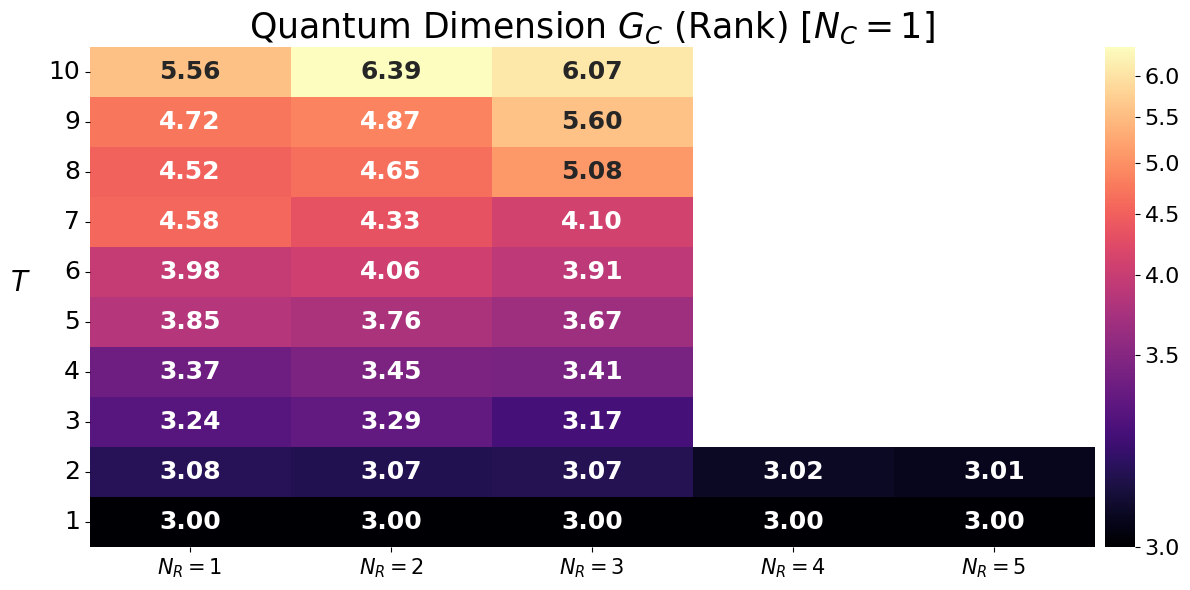

global_min: 3.0, global_max: 10.0


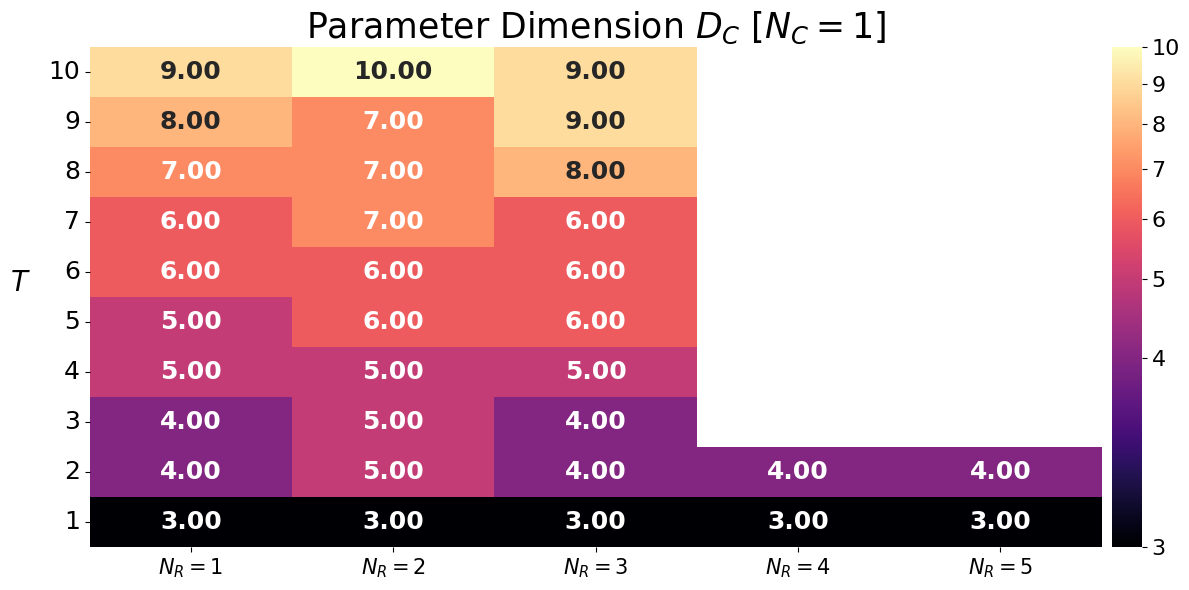

global_min: 74.89942021703702, global_max: 1040.0011578115048


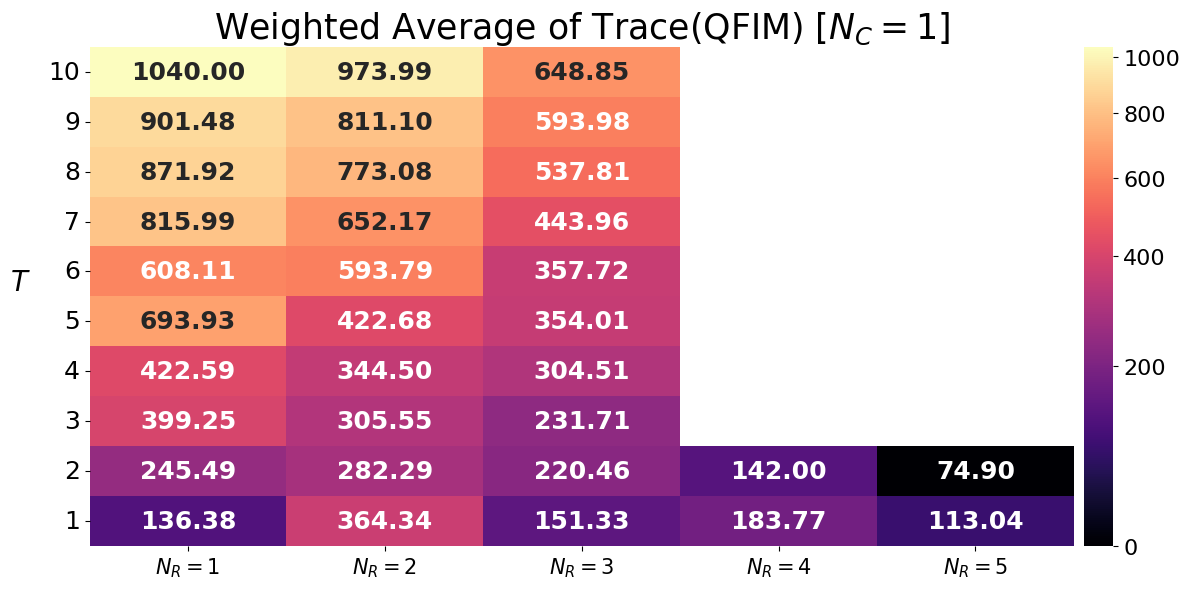

global_min: 643.7281994909622, global_max: 44882.5796279897


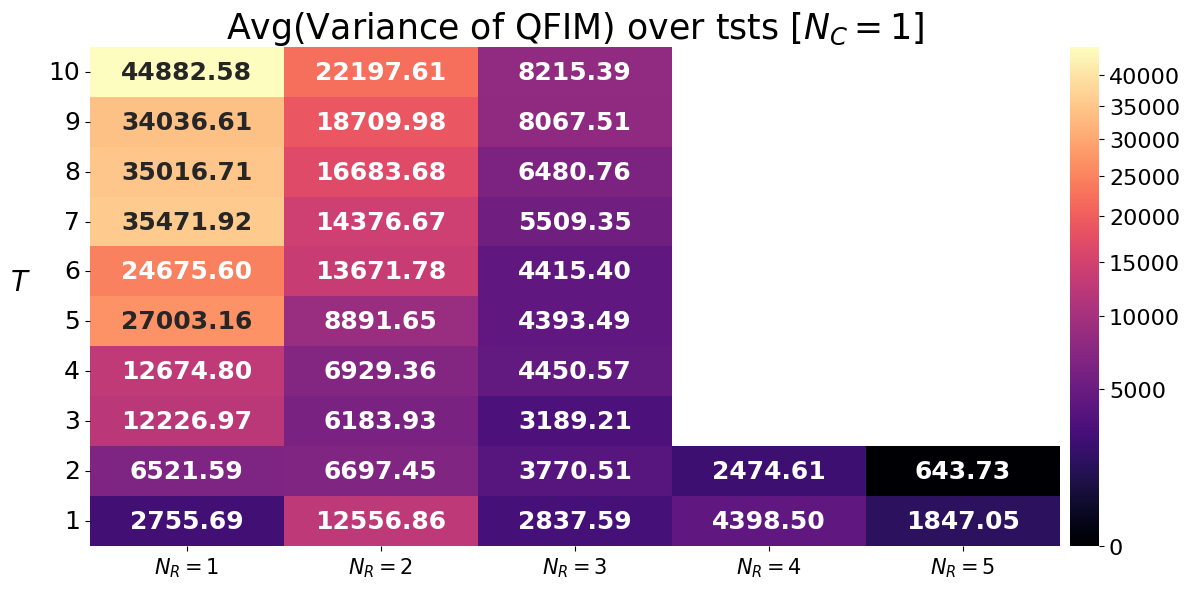

global_min: 60.11937915313454, global_max: 905.5168407174269


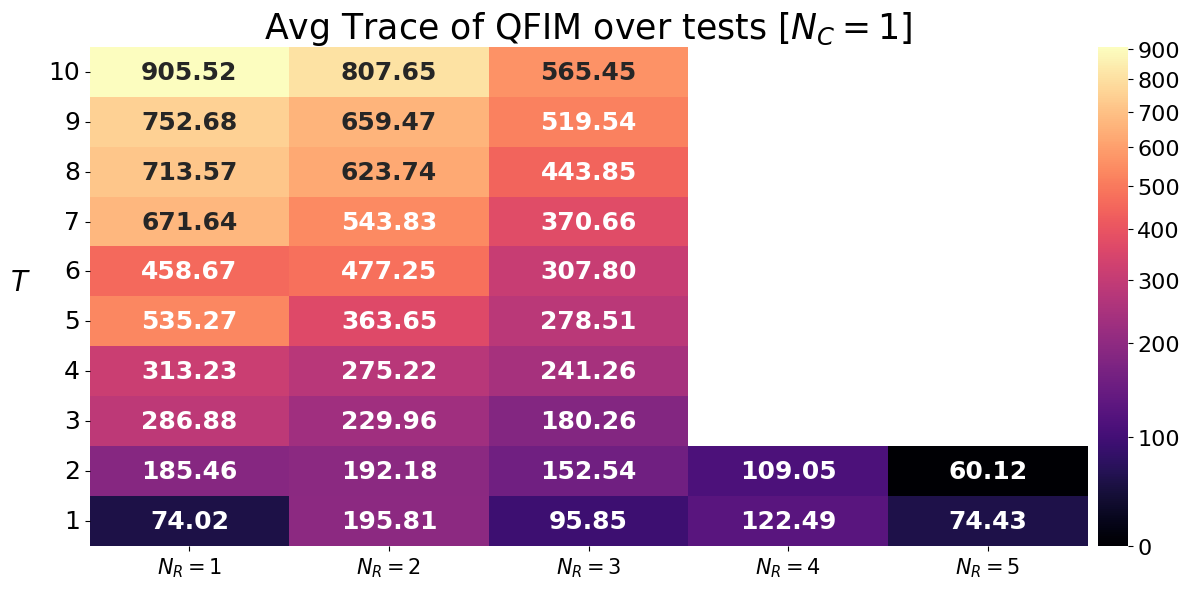

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_ctrl = 1
metric_keys = ['quantum_dim', 'D_C','var_power_scaled_avg_qfim_eigvals','avg_test_var_qfim_eigvals', 'avg_test_var_qfim_eigvals_normalized','var_test_var_qfim_eigvals_normalized']
# metric_keys = ['quantum_dim','redundancies','mean_entropy', 'weighted_avg_trace_eigvals','var_power_scaled_avg_qfim_eigvals','var_power_scaled_avg_qfim_eigvals_nonzero']
# metric_keys = ['weighted_avg_trace_eigvals','var_power_scaled_avg_qfim_eigvals','test_var_qfim_eigvals_nonzero']
metric_keys = ['quantum_dim', 'D_C','weighted_avg_trace_eigvals', 'avg_test_var_qfim_eigvals','avg_test_tr_qfim_eigvals']
metric_titles = [
    f'Trace(QFIM) ($N_C = {N_ctrl}$)',
    f'Trace(QFIM) IQR ($N_C = {N_ctrl}$)',
    f'VN Entropy ($N_C = {N_ctrl}$)',
    f'Variance Non-Zero $\mathcal{{Q}}$ Eigenvalues IQR ($N_C = {N_ctrl}$)',

]
metric_cbars = [
    f'Tr($\mathcal{{Q}}$)',
     f'Tr($\mathcal{{Q}}$)',
    r'$S_{VN}$',
    f'Var($\lambda_\mathcal{{Q}}$)',
]
resies = [1,2, 3]
metrics_info = {
    # Trace Metrics
    'mean_trace_eigvals': {
        'title': f'Mean Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    'avg_test_tr_qfim_eigvals': {
        'title': f'Avg Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_trace_eigvals': {
        'title': f'IQR of Trace(QFIM) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_trace_eigvals': {
        'title': f'Weighted Average of Trace(QFIM) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Variance of Eigenvalues
    'mean_var_eigval': {
        'title': f'Mean Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals_normalized': {
        'title': f'log Var(Variance of QFIM) over tsts (normalized) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals': {
        'title': f'Avg(Variance of QFIM) over tsts [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_var_eigval': {
        'title': f'Median Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_var_eigval': {
        'title': f'IQR of Variance(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_var_eigval': {
        'title': f'Weighted Average Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'normalized_var_qfim_eigvals': {
        'title': f'Normalized Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals': {
        'title': f'Var(Variance of QFIM) over tsts  [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Variance of Log-Scaled Eigenvalues
    'mean_var_log_eigval': {
        'title': f'Mean Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_var_log_eigval': {
        'title': f'Median Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_var_log_eigval': {
        'title': f'IQR of Variance(log(QFIM Eigenvalues)) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_var_log_eigval': {
        'title': f'Weighted Average Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Entropy
    'mean_entropy': {
        'title': f'Mean Von Neumann Entropy [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'entropy': {
        'title': f'Von Neumann Entropy Distribution [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Condition Numbers
    'mean(cond_nums)': {
        'title': f'Mean Condition Number of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'cond_nums': {
        'title': f'Condition Numbers of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Eigenvalue Metrics
    'max_eigvals': {
        'title': f'Maximum QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'min_eigvals': {
        'title': f'Minimum QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Ratios and Redundancies
    'ratios': {
        'title': f'Ratio of Non-Zero Eigenvalues to Parameters [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'redundancies': {
        'title': f'Redundancy ($G_C$)[$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'global_redundancies': {
        'title': f'Global Redundancy ($D_C$) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Quantum Dimension
    'quantum_dim': {
        'title': f'Quantum Dimension $G_C$ (Rank) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'D_C': {
        'title': f'Parameter Dimension $D_C$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'effective params': {
        'title': f'Effective Parameters [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Normalized Trace
    'mean_norm_trace_eigvals': {
        'title': f'Mean Normalized Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Power-Scaled Metrics
    'var_power_scaled_avg_qfim_eigvals': {
        'title': f'Power-Scaled Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_power_scaled_avg_qfim_eigvals_nonzero': {
        'title': f'Power-Scaled Variance of Non-Zero QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Variance of Log Scaled Metrics
    'var_log_qfim_eigvals_nonzero': {
        'title': f'Variance of log(QFIM Eigenvalues) Non-Zero [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Trace Values Direct
    'trace_eigvals': {
        'title': f'Trace of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    }
}

# resies = [1]
resies = [1, 2 ,3,4,5]

for idx,metric_key in enumerate(metric_keys):
    # Retrieve title and color bar from the dictionary
    metric_title = metrics_info[metric_key]['title']
    metric_cbar = metrics_info[metric_key]['cbar']
    
    # Filter the data for the current N_ctrl
    df_filtered = df_all[df_all['N_ctrl'] == N_ctrl][['N_reserv', 'Trotter_Step', f'{metric_key}']]
    
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    elif N_ctrl ==3:
        trots = np.arange(1,40,1)
    else:
        trots = [1,2,3,4,6,8,10,12,14,16,20,24]
    
    df_filtered = df_filtered[df_filtered['Trotter_Step'].isin(trots)]
    df_filtered = df_filtered[df_filtered['N_reserv'].isin(resies)]
    
    # Aggregate the data by Trotter_Step and N_reserv
    df_heatmap = df_filtered.groupby(['Trotter_Step', 'N_reserv']).agg({metric_key: 'mean'}).reset_index()
    min_val = df_heatmap[metric_key].min()

    max_val = df_heatmap[metric_key].max()
    # print(df_heatmap.keys())
    print(f"global_min: {min_val}, global_max: {max_val}")
    # Pivot the data to create a heatmap
    heatmap_pivot = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values=metric_key)
    if metric_key in [ '']:
        # k = 0
        annotation_matrix = heatmap_pivot.map("{:.0f}".format)  # Ensures integer formatting

    else:
        # k = 2
        annotation_matrix = heatmap_pivot.map("{:.2f}".format)  # Ensures integer formatting

    

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    if metric_key.startswith('var_power_scaled'):
        sns.heatmap(heatmap_pivot,annot=annotation_matrix,fmt="s", ax=ax,cbar_ax=cax,  cmap='magma', annot_kws={"weight": "bold", "size": 18},norm=PowerNorm(gamma=0.4, vmin=min_val, vmax=max_val))
    else:
        sns.heatmap(heatmap_pivot,annot=annotation_matrix,fmt="s", ax=ax,cbar_ax=cax,  cmap='magma', annot_kws={"weight": "bold", "size": 18},norm=PowerNorm(gamma=0.5, vmin=min_val, vmax=max_val))
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)  # Adjust the color bar tick label size
    cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)  # Rotate and set label size and weight

    ax.set_title(metric_title, fontsize=25)
    ax.set_ylabel('$T$', labelpad=20, fontsize=20, rotation=0)
    ax.set_xlabel('', fontsize=20)
    ax.tick_params(axis='y', labelrotation=0, labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(ax.get_xticklabels()))], fontweight='bold', fontsize=15, rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:

for N_ctrl in N_ctrls:
    
    model_path = base_path / 'QFIM_traced_trainable_global' / model_type / f'Nc_{N_ctrl}' / base_state
    for Nr in sorted(os.listdir(model_path)):
        Nr_path = model_path / Nr
        if not Nr_path.is_dir():
            continue
        #data[Nr] = {}
        for trotter_step in sorted(os.listdir(Nr_path)):
            trotter_step_path = Nr_path / trotter_step
            if not trotter_step_path.is_dir():
                continue
            data_file = trotter_step_path / 'data.pickle'
            
            if is_valid_pickle_file(data_file):
                # print(data_file)
                with open(data_file, 'rb') as f:
                    df = pickle.load(f)
                    trotter_step_num = int(trotter_step.split('_')[-1])
                    processed_data = process_data_combined(df, threshold, by_test, int(Nr.split('_')[-1]), trotter_step_num, False)
                    processed_data.update({
                        'N_ctrl': N_ctrl,
                        'N_reserv': int(Nr.split('_')[-1]),
                        'Trotter_Step': trotter_step_num
                    })
                    all_data.append(processed_data)

# Convert the list of dictionaries to a DataFrame
df_all = pd.DataFrame(all_data)

# Display the combined DataFrame
print(df_all)